# DSL Assessment: prijsvoorspelling voor Airbnb’s in Berlijn
### Door Cees Kaandorp

<br/><br/>
Hallo Robert! In dit notebook heb ik mijn uitwerking van het assessment weergegeven. Ik heb:
- De data opgeschoond en geanalyseerd met *NumPy* en *Pandas*.
- De lineaire modellen (Linear Regression, Lasso, Ridge) geimplementeerd met *scikit-learn*.
- Een Gradient Boosting model *xgboost* geimplementeerd met de gelijknamige library.
<br/><br/>

Een korte samenvatting van mijn aanpak:

__[1. Natuur van de data en het probleem begrijpen](#nature):__ 

- Het verzamelen van basisinformatie over de data.
- Nadenken over het gegeven probleem: het probleem structureren en hypotheses stellen.

__[2. Data opschonen](#opschonen):__ 

- Lege velden verwijderen/vervangen.
- Data in het correcte formaat zetten voor de analyse.

__[3. Feature Analysis/Engineering](#engineering)__:
- Afhankelijke variable: Distributie bestuderen en outliers verwijderen.
- Numerieke features:
    - Correlation Heatmap: Kijken voor correlaties met prijs en multicollinearity. 
    - Irrelevante features verwijderen.
- Categoriale features: 
    - Irrelevante features verwijderen.
    - Class frequencies bekijken en kolommen met extreme inbalances verwijderen.
- Features verdelen in semantische categorieen en analyseren:
    - Host, Beschikbaarheid, Boeken, Kosten, Host, Huis, Locatie.
    - Trends in de data bekijken.
    - Hypotheses toetsen.
   
__[4. Feature preprocessing](#preprocessing)__: 
- Categoriale features one-hot encoden.
- Data splitten in test en training.
- Data schalen.

__[5. Model experimenten](#ml)__:
- Baseline model/Sanity Check.
- Linear Regression.
- Ridge Regression.
- Lasso Regression.
- Gradient Boosting: XGBoost.

Aan het einde reflecteer ik nog op wat ik kan verbeteren en waar het model voor gebruikt zou kunnen worden.

## Imports

In [93]:
# Data Wrangling
import numpy as np 
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data type manipulation
import ast
import locale

# Machine learning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 500

<a id='nature'> <h2> (1) Natuur van de data en het probleem begrijpen</h2></a>

De allereerste stap is om de data in te lezen en wat basisinformatie te verzamelen. Ik kijk hier vooral naar de grootte van de dataset en de verschillende types data die zich voordoen. Daarnaast probeer ik tijdens deze fase goed over het probleem na te denken en hypotheses te stellen die ik later kan toetsen in een analyse. In dit geval heb ik de kolommen semantisch verdeeld in categorieën en daarbij wat hypotheses opgesteld (op basis van mijn domein kennis):

- __Host:__ `[host_id, host_listings_count, host_total_listings_count, calculated_host_listings_count, host_verifications identity_verified, host_neighbourhood, host_is_superhost]`
	- *Superhosts verhuren door hun status duurdere huizen.*
    - *Het totale aantal listings van de huurder heeft invloed op de vraagprijs.*
    - *Een host met meer/bepaalde verifications verhuurt duurdere huizen.*
    
    
- __Locatie:__ `[latitude, longitude, neighbourhood_group_cleansed, neighbourhood_cleansed, neighbourhood]`
	- *AirBnbs zijn duurder in het centrum.*
    - *AirBnBs zijn duurder in bepaalde wijken (meer richting het centrum).*
    
    
- __Huis:__ `[accommodates, bathrooms, bedrooms, beds, bed_type, room_type, property_type]`
	- *Een groter huis met meer/luxere voorzieningen zal meer kosten.*
    - *Het type huis zegt wat over de grootte en heeft daardoor invloed op de vraagprijs*
    
    
- __Prijs:__ `[price, security_deposit, cleaning_fee, guests_included, extra_people]`
	- *Een duurder huis heeft meer extra kosten.*
    
    
- __Beschikbaarheid:__ `minimum_nights, maximum_nights, availability 30-365`
	- *Het minimaal aantal nachten is hoger bij duurdere huizen.*
    - *Een duurder huis is heeft een lagere beschikbaarheid, omdat deze wellicht populairder is.*
    
    
- __Boeken:__ `[cancellation_policy, instant_bookable]`
	- *Duurdere listings hebben een strenger annuleringsbeleid en zijn minder vaak gelijk te boeken*
    
    
- __Reviews:__ `['first_review', 'last_review', 'number_of_reviews', 'review_scores_rating',  'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']`
   - *Een duurder huis heeft betere reviews.*
   - *Een duurder huis wordt vaker gehuurd en heeft daarom meer reviews.*
    
Dit helpt om het probleem meer in te kaderen en te structureren. Tenslotte verwijder ik de potentiële dubbele rijen die zich in de dataset bevinden

In [94]:
df = pd.read_csv('data/listings_summary.csv')
df = df.drop_duplicates()

df_original = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22552 entries, 0 to 22551
Data columns (total 96 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22552 non-null  int64  
 1   listing_url                       22552 non-null  object 
 2   scrape_id                         22552 non-null  int64  
 3   last_scraped                      22552 non-null  object 
 4   name                              22493 non-null  object 
 5   summary                           21589 non-null  object 
 6   space                             14020 non-null  object 
 7   description                       22349 non-null  object 
 8   experiences_offered               22552 non-null  object 
 9   neighborhood_overview             11540 non-null  object 
 10  notes                             7215 non-null   object 
 11  transit                           13036 non-null  object 
 12  acce

In [3]:
df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,96%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,3 months ago,t,0,21,51,141,2018-11-07,118,2016-04-11,2018-10-28,93.0,10.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,NaN,Within walking distance you'll find the S-Bahn...,Außer deinem Zimmer kannst du noch die Küche u...,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/97d4f6e8-1...,NaN,2986,https://www.airbnb.com/users/show/2986,Michael,2008-09-16,"Berlin, Berlin, Germany",Living with my wife in Berlin. Like travellin...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/50434955-1...,https://a0.muscache.com/im/pictures/50434955-1...,Prenzlauer Berg,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",NaN,Prenzlauer Berg Nordwest,Pankow,Berlin,Berlin,10437,Berlin,"Berlin, Germany",DE,Germany,52.548513,13.404553,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",NaN,$17.00,NaN,NaN,$0.00,$0.00,1,$0.00,2,40,7 weeks ago,t,0,0,0,0,2018-11-07,6,2018-07-04,2018-10-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,NaN,f,f,flexible,f,f,1,1.42


<br/><br/>
<a id='opschonen'> <h2> (2) Data opschonen</h2></a>


In deze fase wil ik de lege velden bestuderen, de lege velden verwijderen/vervangen en waarnodig de data in een correct formaat zetten voor de analyse.

Eerst plot ik een heatmap van de lege velden, waarin je in één oogopslag de verdeling van null values over je hele dataset kunt zien.

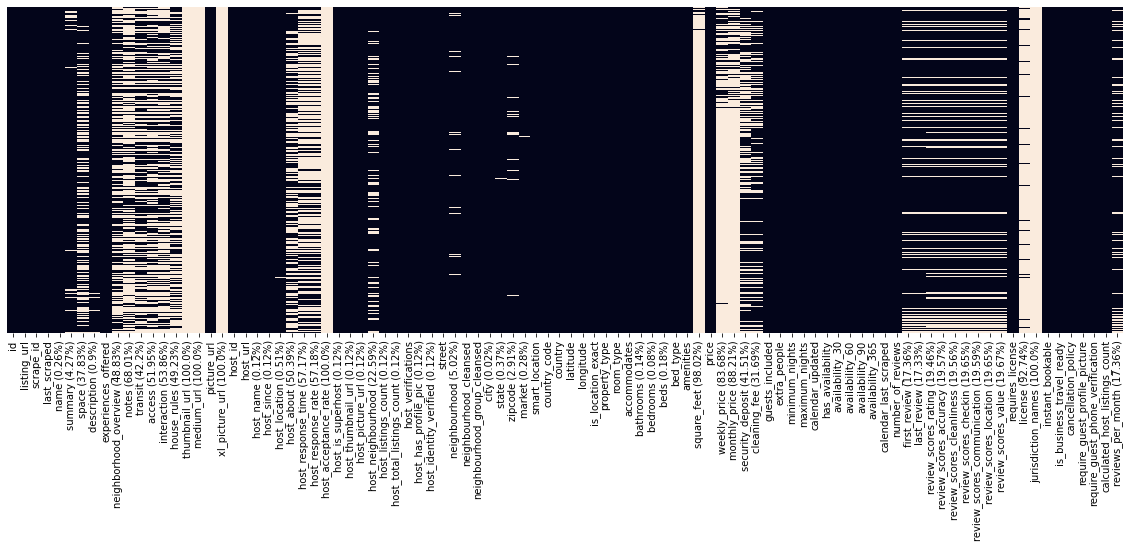

In [4]:
plt.figure(figsize=(20,6))

def null_heatmap(df, nulls_only=False):
    tick_labels = []

    if nulls_only:
        df = df[df.columns[df.isnull().any()]]

    for col, nulls in zip(df.columns, df.isnull().sum()):
        if nulls/len(df) > 0:
            tick_labels.append(f'{col} ({str(round(nulls/len(df)*100, 2))}%)')
        else: 
            tick_labels.append(col)

    null_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False)
    null_heatmap.set_xticklabels(tick_labels);

null_heatmap(df)

Hier zien we een aantal kolommen die bijna helemaal leeg zijn, deze kunnen we bij voorbaat verwijderen. 



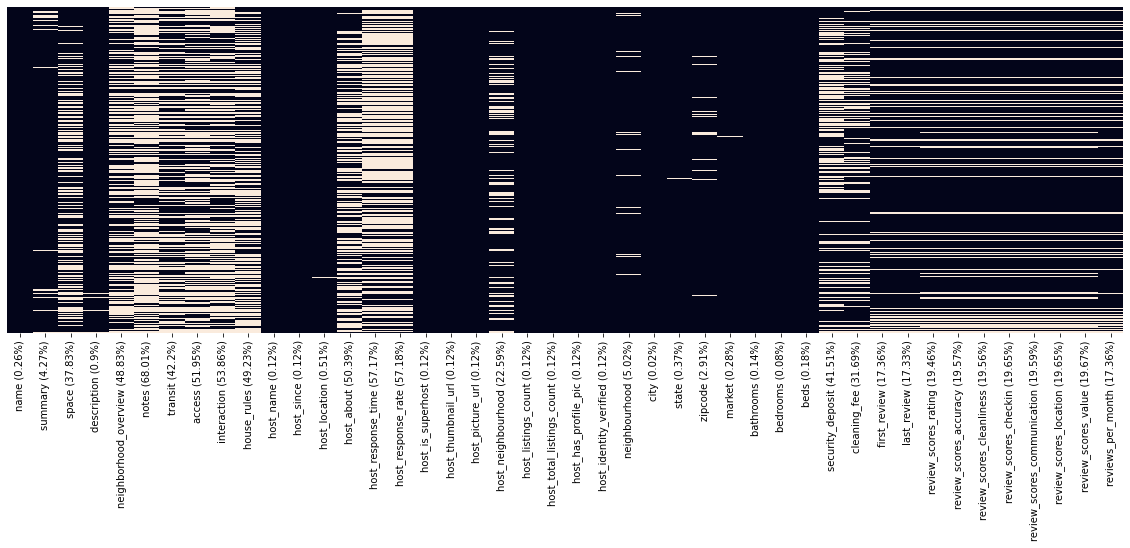

In [5]:
# Kolommen bij voorbaat droppen wanneer ze extreem veel missing values hebben
df.drop(['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate',
         'square_feet', 'weekly_price', 'monthly_price',
         'license', 'jurisdiction_names'], axis=1, inplace=True)

plt.figure(figsize=(20,6))
null_heatmap(df, nulls_only=True)         

Vervolgens hou je nog een aantal kolommen over die lege velden bevatten, deze bestudeer ik aandachtiger: Ik probeer te achterhalen wat de reden kan zijn dat er lege velden zijn en of ze misschien te vullen zijn.

In [6]:
# Text features met heel veel missende data zijn bijna niet te interpoleren
df.drop(['space', 'neighborhood_overview', 'notes', 
         'transit', 'access', 'interaction', 
         'house_rules', 'host_about', 'host_neighbourhood', 
         'summary', 'description'], axis=1, inplace=True)
         
# We hebben voor deze kolom een alternatief zonder missing values, namelijk: neighbourhood_cleansed
df.drop(['neighbourhood'], axis=1, inplace=True)

# De nulls uit de kolommen host_name, host_since, host_is_superhost, host_thumbnail_url, host_picture_url, host_has_profile pic 
# en host_identity verified komen uit dezelfde rijen, dit is een heel klein percentage (0.12%), dus deze rijen droppen we. 
df = df[df['host_name'].notna()]

<br></br>
Omdat `host_response_time` en `host_response_rate` mij wel interessant lijken voor dit probleem, besluit ik de lege velden in te vullen met 'unknown' om aan te geven dat de reactietijd hier onbekend was.

In [7]:
df['host_response_time'].fillna('unknown', inplace=True)
df['host_response_rate'].fillna('unknown', inplace=True)

Er zijn 4 kolommen die prijsinformatie bevatten, deze staan in een formaat ('$') waarmee we geen analyse kunnen doen. Deze data zet ik om naar floats. Daarnaast bevatten `cleaning_fee` en `security_deposit` lege velden, ik heb besloten aan te nemen dat deze lege velden erop wijzen dat er geen kosten waren en ik ze dus met 0 kan invullen.

In [8]:
price_columns = ['price','cleaning_fee', 'security_deposit', 'extra_people']
df[price_columns].head(3)

,price,cleaning_fee,security_deposit,extra_people
0,$60.00,$30.00,$200.00,$28.00
1,$17.00,$0.00,$0.00,$0.00
2,$90.00,$50.00,$200.00,$20.00


In [9]:
def dollar_to_float(col):
    locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
    to_float = [locale.atof(i.strip("$")) for i in col]
    return to_float

for i in price_columns:
    df[i] = df[i].fillna('0.00')
    df[i] = dollar_to_float(df[i])

Het aantal bathrooms, bedrooms en beds besluit ik in te vullen met de mediaan. Omdat dit zo'n aanzienlijk klein percentage is zal dit geen enorme invloed hebben op de distributie. De lege velden van de reviews besluit ik in te vullen met het gemiddelde.

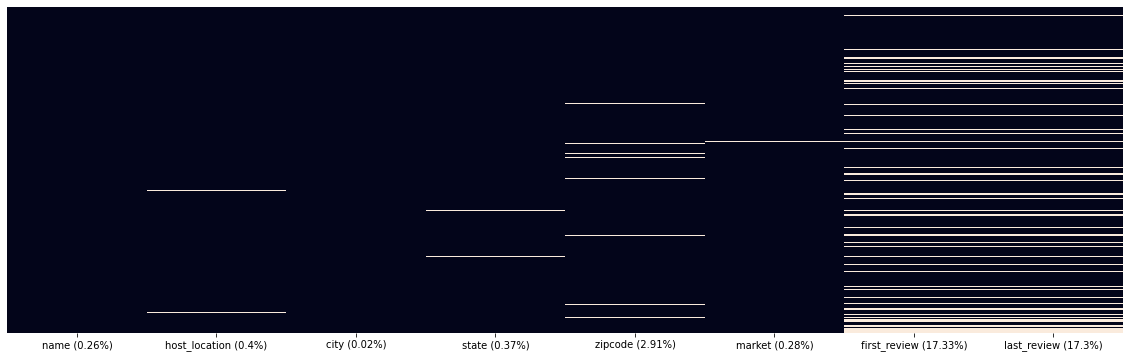

In [10]:
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['beds'].fillna(df['beds'].median(), inplace=True)

review_cols = ['review_scores_rating',  'review_scores_rating', 'review_scores_accuracy', 
'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
'review_scores_location', 'review_scores_value']

for i in review_cols:
    df[i].fillna(df[i].mean(), inplace=True)

df['reviews_per_month'].fillna(0, inplace=True)
plt.figure(figsize=(20,6))
null_heatmap(df, nulls_only=True)

We houden nog een aantal kolommen over die niet vanzelfsprekend met iets ingevuld kunnen worden, ik heb besloten deze voor nu even zo te laten. We zouden natuurlijk de meest frequente categorieen kunnen invullen of rijen verwijderen, maar vooral dat laatste wil ik zoveel mogelijk voorkomen. Ik ga liever nu eerst de features analyseren, wanneer dan blijkt dat de features uberhaupt niet nuttig zijn, kan ik gewoon de kolom niet meenemen en hoef ik hierdoor geen data op te offeren

<br/><br/>
<a id='engineering'> <h2> (3) Feature Analysis/Engineering</h2></a>

Het hoofddoel van deze fase is om features te filteren, te analyseren en eventueel nieuwe toe te voegen. Te veel complexiteit (Curse of Dimensionality) of slechte features voor het model kunnen leiden tot ongewenste resultaten. Het model is maar zo goed als de data die je er in stopt, daardoor is dit een erg belangrijke stap. Hierbij let ik vooral op outliers, collineare features en redundant features. Daarnaast toets ik tijdens deze stappen mijn hypotheses.

Als eerste stap kijk ik naar de verdeling van onze afhankelijke variabele, in dit geval willen we de prijs voorspellen en ga ik kijken of we eventuele bijzonderheden kunnen vinden in deze kolom.

### De Afhankelijke variabele

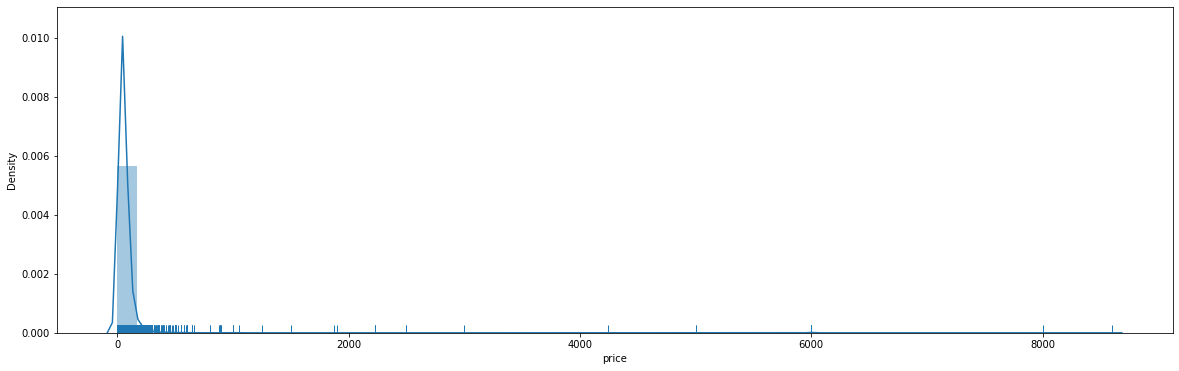

In [11]:
plt.figure(figsize=(20,6))
sns.distplot(df['price'],rug=True);

Op de plot is te zien dat we te maken hebben met enkele outliers, deze hebben over het algemeen een groot effect op de regressie loss en zorgen voor mindere statistische voorspellingskracht. Ik heb besloten om de rijen boven de 350,- per nacht te verwijderen, dit zijn maar 133 rijen en geeft ons een veel betere distributie om mee te werken

In [72]:
print(df['price'].describe())
lost_data = len(df[df['price'] > 350])
print(f'Aantal rijen dat we verliezen na een cut_off van 350: {lost_data}')

count    22526.000000
mean        66.771020
std        212.201084
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       8600.000000
Name: price, dtype: float64
Aantal rijen dat we verliezen na een cut_off van 350: 133


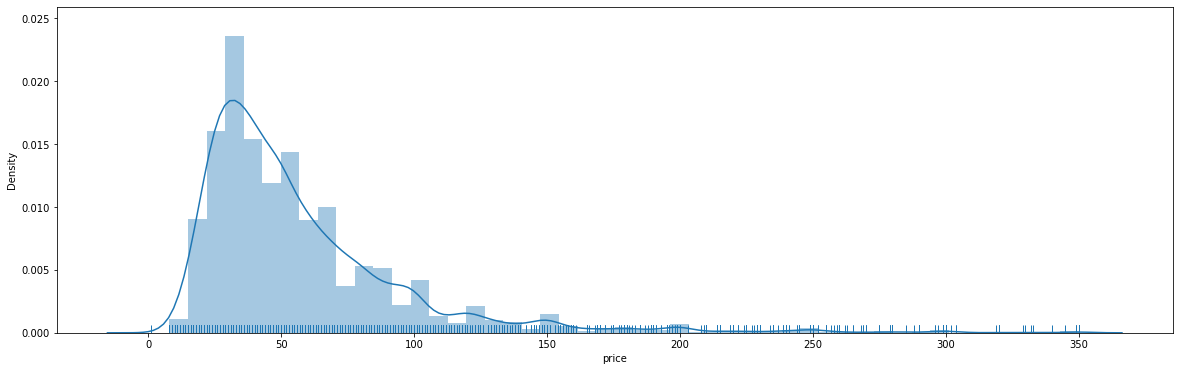

In [73]:
plt.figure(figsize=(20,6))
df = df[(df['price'] <= 350) & (df['price'] != 0)]
sns.distplot(df['price'],rug=True);

<br/><br/>
Nu splits ik onze features op numerieke en categoriale features. Dit doe ik omdat beide types data een andere soort analyse vergen.

<br></br>
Nu splits ik onze features op numerieke en categoriale features. Dit doe ik omdat beide types data een andere soort analyse vergen.
### Numeric features

In [74]:
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
df_num = df[numeric_features]
df_num.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,2.238500e+04,2.238500e+04,2.238500e+04,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,2.238500e+04,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000,22385.000000
mean,1.570390e+07,2.018111e+13,5.389240e+07,2.313916,2.313916,52.509820,13.406256,2.618361,1.088809,1.152960,1.608354,57.138664,116.887693,18.069779,1.324950,8.256154,7.177083,1.038134e+05,4.879830,11.021354,19.833683,79.180746,17.883672,94.413277,9.664517,9.324674,9.713193,9.730824,9.506109,9.412212,1.901631,0.941123
std,8.547907e+06,0.000000e+00,5.806087e+07,20.005656,20.005656,0.030859,0.057887,1.454926,0.317359,0.620787,1.138455,40.354087,298.808367,24.512029,0.803192,11.110424,40.799522,9.676411e+06,8.608033,17.391011,28.180013,118.784108,36.834870,6.860912,0.662616,0.926326,0.632931,0.615730,0.683847,0.754752,3.655703,1.438055
min,2.015000e+03,2.018111e+13,2.217000e+03,0.000000,0.000000,52.345803,13.103557,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000
25%,8.064973e+06,2.018111e+13,9.228021e+06,1.000000,1.000000,52.489009,13.375651,2.000000,1.000000,1.000000,1.000000,30.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,93.000000,9.664331,9.000000,9.713426,9.730865,9.000000,9.000000,1.000000,0.070000
50%,1.684308e+07,2.018111e+13,3.119025e+07,1.000000,1.000000,52.509080,13.416918,2.000000,1.000000,1.000000,1.000000,45.000000,0.000000,10.000000,1.000000,5.000000,3.000000,1.124000e+03,0.000000,0.000000,0.000000,4.000000,5.000000,95.000000,10.000000,9.325519,10.000000,10.000000,9.505688,9.411567,1.000000,0.340000
75%,2.255796e+07,2.018111e+13,8.020618e+07,2.000000,2.000000,52.532693,13.439322,3.000000,1.000000,1.000000,2.000000,70.000000,150.000000,30.000000,1.000000,15.000000,4.000000,1.125000e+03,6.000000,17.000000,36.000000,128.000000,16.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.180000
max,2.986735e+07,2.018111e+13,2.245081e+08,1676.000000,1676.000000,52.651670,13.757642,16.000000,8.500000,9.000000,22.000000,350.000000,4280.000000,450.000000,16.000000,250.000000,5000.000000,1.000000e+09,30.000000,60.000000,90.000000,365.000000,498.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,45.000000,36.670000


Hieronder plot ik de correlaties van de numerieke features, hierbij wil ik twee dingen bereiken:

__1. Collineaire  Features filteren:__ We willen dat de onafhankelijke variabelen zoveel mogelijk onafhankelijk van elkaar zijn.

__2. Correlaties met afhankelijke variabele bekijken:__ Dit duidt op een lineare relatie tussen de feature en de prijs en kan dus goed helpen met voorspellen

<AxesSubplot:>

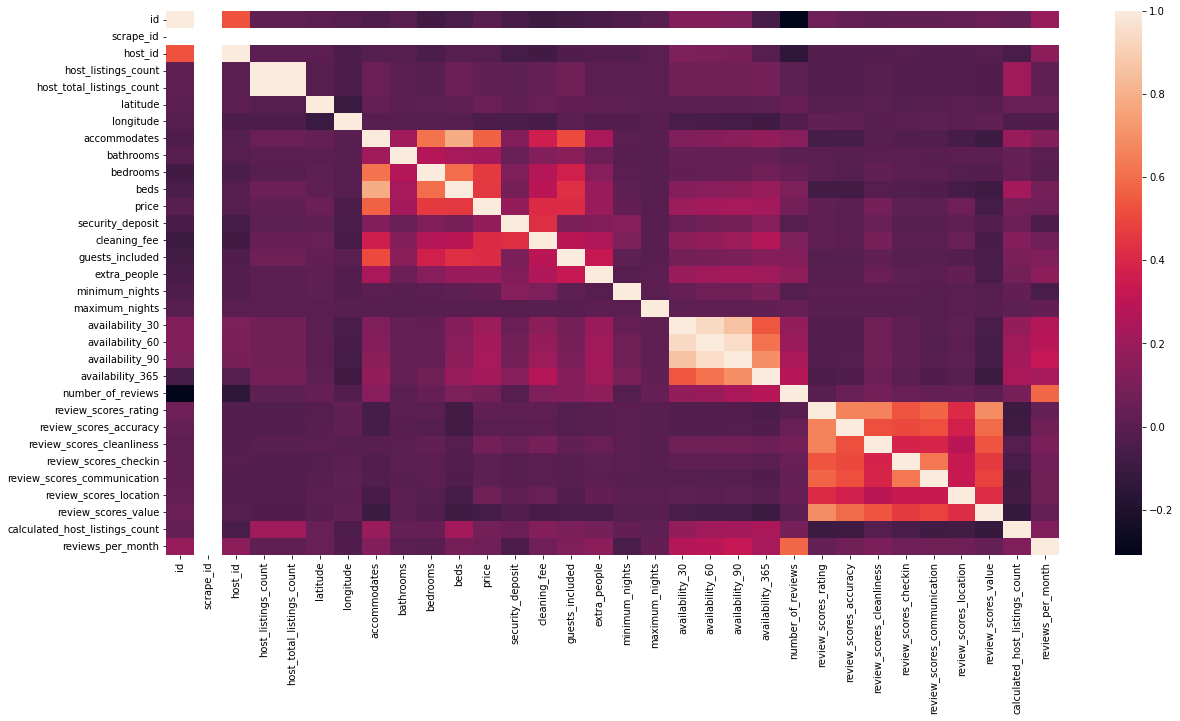

In [75]:
plt.figure(figsize=(20,10))
sns.heatmap(df_num.corr())

Ik zie een paar groepen met collineaire features, in dit geval kies ik er per groep eentje uit die het meest correleert met de prijs: 
- `host_total_listings_count, total_listings_count` --> `total_listings_count`


- `availability_30, availability_60, availability_90, availability_365` --> `availability_90`


- `accommodates, beds` --> `accommodates`


- `review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, reviews_per_month` --> `review_scores_rating`

Daarnaast verwijder ik features die niet relevant zijn voor het probleem, in dit geval identifiers. Deze kolommen zijn meestal veelal uniek voor elke rij en geven dus geen informatie.

In [76]:
# Collineaire  Features
df_num.drop(['host_total_listings_count', 'availability_30', 
             'availability_60', 'availability_365', 'beds', 
             'review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin', 'review_scores_communication', 
             'review_scores_location', 'review_scores_value', 'reviews_per_month'], axis=1, inplace=True)

# Zijn niet relevant voor ons probleem
df_num.drop(['id', 'scrape_id', 'host_id'], axis=1, inplace=True)

<br/><br/>
### Categorical Features

In [77]:
df_cat = df.drop(numeric_features, axis=1)
df_cat.head(3)

,listing_url,last_scraped,name,experiences_offered,picture_url,host_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/2015,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,none,https://a0.muscache.com/im/pictures/260fd609-7...,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",within an hour,96%,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,f,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",3 months ago,t,2018-11-07,2016-04-11,2018-10-28,t,f,f,strict_14_with_grace_period,f,f
1,https://www.airbnb.com/rooms/2695,2018-11-07,Prenzlauer Berg close to Mauerpark,none,https://a0.muscache.com/im/pictures/97d4f6e8-1...,https://www.airbnb.com/users/show/2986,Michael,2008-09-16,"Berlin, Berlin, Germany",unknown,unknown,f,https://a0.muscache.com/im/pictures/50434955-1...,https://a0.muscache.com/im/pictures/50434955-1...,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",Prenzlauer Berg Nordwest,Pankow,Berlin,Berlin,10437,Berlin,"Berlin, Germany",DE,Germany,t,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",7 weeks ago,t,2018-11-07,2018-07-04,2018-10-01,t,f,f,flexible,f,f
2,https://www.airbnb.com/rooms/3176,2018-11-07,Fabulous Flat in great Location,none,https://a0.muscache.com/im/pictures/243355/84a...,https://www.airbnb.com/users/show/3718,Britta,2008-10-19,"Coledale, New South Wales, Australia",within a day,100%,f,https://a0.muscache.com/im/users/3718/profile_...,https://a0.muscache.com/im/users/3718/profile_...,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,"Berlin, Berlin, Germany",Prenzlauer Berg Südwest,Pankow,Berlin,Berlin,10405,Berlin,"Berlin, Germany",DE,Germany,t,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",a week ago,t,2018-11-07,2009-06-20,2017-03-20,t,t,f,strict_14_with_grace_period,f,f


Bij het bekijken van de categoriale features vielen mij meteen al veel features op die niet relevant zijn voor het probleem

In [78]:
# Urls geven geen verdere informatie over de prijs
df_cat.drop(['listing_url', 'picture_url', 'host_thumbnail_url', 'host_url', 'host_picture_url'], axis=1, inplace=True)

# host_name en name zijn eigenlijk ook een soort identifiers, en de datum van aanmelding lijkt me niet relevant
df_cat.drop(['host_since', 'name', 'host_name'], axis=1, inplace=True)

# Scraping informatie lijkt me niet relevant voor het probleem
df_cat.drop(['last_scraped', 'calendar_last_scraped', 'calendar_updated'], axis=1, inplace=True)

# Ik verwijder hier first en last review omdat eerder de inhoud van de reviews mij relevant lijken en niet de datums van de eerste en tweede.
df_cat.drop(['first_review', 'last_review'], axis=1, inplace=True)

In [79]:
df_cat.head(3)

,experiences_offered,host_location,host_response_time,host_response_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,has_availability,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,none,"Key Biscayne, Florida, United States",within an hour,96%,t,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,f,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",t,t,f,f,strict_14_with_grace_period,f,f
1,none,"Berlin, Berlin, Germany",unknown,unknown,f,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",Prenzlauer Berg Nordwest,Pankow,Berlin,Berlin,10437,Berlin,"Berlin, Germany",DE,Germany,t,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",t,t,f,f,flexible,f,f
2,none,"Coledale, New South Wales, Australia",within a day,100%,f,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,"Berlin, Berlin, Germany",Prenzlauer Berg Südwest,Pankow,Berlin,Berlin,10405,Berlin,"Berlin, Germany",DE,Germany,t,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",t,t,t,f,strict_14_with_grace_period,f,f


Nu wil ik kijken naar de verdeling van categorieen per feature: als er enorme class inbalansen zijn verwijder ik de kolom. Bijvoorbeeld als een feature 95 procent bestaat uit 1 class geeft dit dus weinig informatie voor onze voorspelling. <a id='class_inbalans'></a>

<AxesSubplot:>

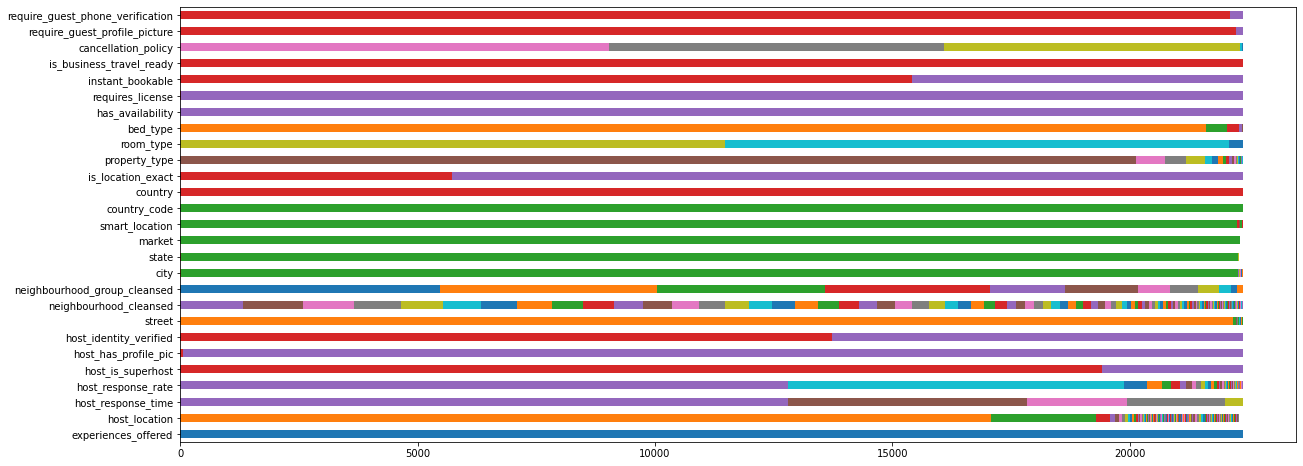

In [80]:
df_visualize = df_cat.drop(['host_verifications', 'amenities', 'zipcode'],axis=1)

m = pd.DataFrame([df_cat[i].value_counts() for i in df_visualize.columns])
m.plot(kind='barh', stacked=True, figsize=(20,8), legend=False)

<AxesSubplot:>

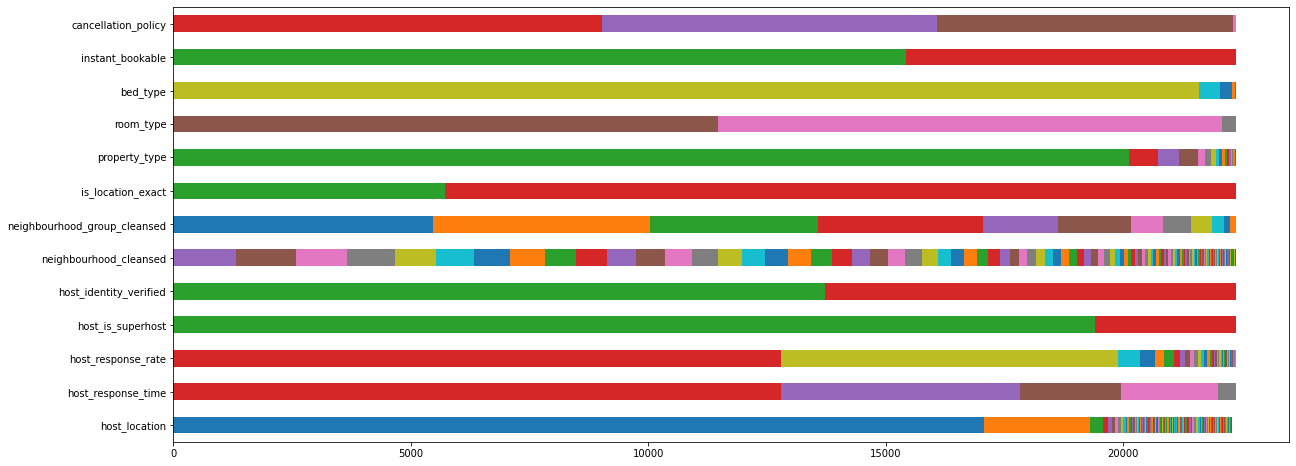

In [81]:
# Alle kolommen verwijderen met grote class imbalansen of die maar bestaan uit 1 class
df_cat = df_cat.drop(['experiences_offered', 'host_has_profile_pic', 'require_guest_profile_picture',
                      'require_guest_phone_verification', 'is_business_travel_ready', 'requires_license',
                      'has_availability', 'country', 'country_code', 'smart_location',
                      'market', 'state', 'city', 'street'], axis=1)
                      
df_visualize = df_cat.drop(['host_verifications', 'amenities', 'zipcode'],axis=1)
m = pd.DataFrame([df_cat[i].value_counts() for i in df_visualize.columns])
m.plot(kind='barh', stacked=True, figsize=(20,8), legend=False)


`host_location` is ook een variabele die eigenlijk veelal hetzelfde is, er worden alleen verschillende namen voor hetzelfde gegeven.

In [82]:
print(df['host_location'].value_counts())
df_cat.drop('host_location', axis=1, inplace=True)

Berlin, Berlin, Germany                   17078
DE                                         2219
Germany                                     289
Hamburg, Hamburg, Germany                   106
US                                           82
                                          ...  
Nevada City, California, United States        1
Bihorel, Normandy, France                     1
Psychiko, Greece                              1
CX                                            1
Reutlingen, Baden-Württemberg, Germany        1
Name: host_location, Length: 1033, dtype: int64


Nu voeg ik de features die we overhouden weer samen en gebruik ik deze voor een verdere analyse.

In [83]:
df = pd.concat([df_num, df_cat], axis=1)
df.head(3)

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,review_scores_rating,calculated_host_listings_count,host_response_time,host_response_rate,host_is_superhost,host_verifications,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,bed_type,amenities,instant_bookable,cancellation_policy
0,4.0,52.534537,13.402557,3,1.0,1.0,60.0,200.0,30.0,1,28.0,4,1125,51,118,93.0,4,within an hour,96%,t,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,Brunnenstr. Süd,Mitte,10119,f,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",f,strict_14_with_grace_period
1,1.0,52.548513,13.404553,2,1.0,1.0,17.0,0.0,0.0,1,0.0,2,40,0,6,100.0,1,unknown,unknown,f,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,Prenzlauer Berg Nordwest,Pankow,10437,t,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",f,flexible
2,1.0,52.534996,13.417579,4,1.0,1.0,90.0,200.0,50.0,2,20.0,62,1125,0,143,92.0,1,within a day,100%,f,"['email', 'phone', 'facebook', 'reviews', 'man...",t,Prenzlauer Berg Südwest,Pankow,10405,t,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",t,strict_14_with_grace_period


<br/><br/>
Ik ga nu per (semantische) categorie af om de features te exploren en te zien wat de effecten van de features zijn op de prijs. Voor elke categorie analyseer ik de data, toets ik de hypotheses en kies ik uiteindelijk de features die mij het meest nuttig lijken.

### Host
`host_listings_count, calculated_host_listings_count, host_identity_verified, host_is_superhost, host_verifications, host_response_time, host_response_rate`

*Verhuurt een professionelere/verified host duurdere huizen?*

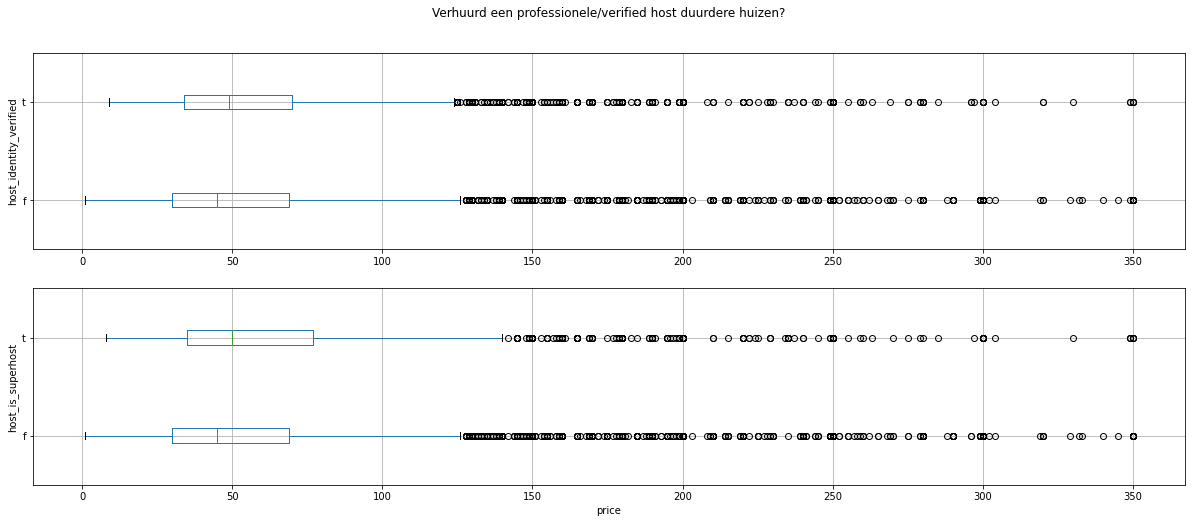

In [147]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
identity = df.boxplot(column='price',  by='host_identity_verified', ax=axes[0], vert=False)
identity.set_xlabel('')
identity.set_ylabel('host_identity_verified')
identity.set_title('')
superhost = df.boxplot(column='price',  by='host_is_superhost', ax=axes[1], vert=False)
superhost.set_xlabel('price')
superhost.set_ylabel('host_is_superhost')
superhost.set_title('')
fig.suptitle('Verhuurt een professionele/verified host duurdere huizen?');

<br></br>
*Reageert de verhuurder van een duur huis sneller/vaker?*

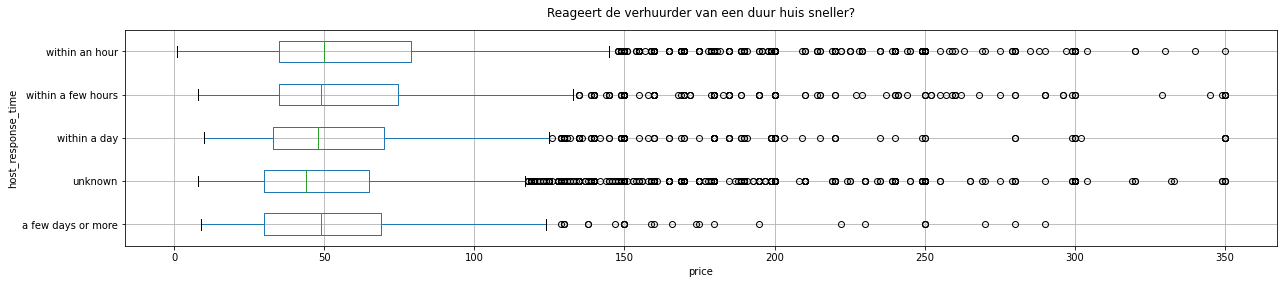

In [100]:
response_time = df.boxplot(column='price', by='host_response_time', vert=False, figsize=(20,4))
response_time.set_xlabel('price')
response_time.set_ylabel('host_response_time')
response_time.set_title('')
plt.suptitle('Reageert de verhuurder van een duur huis sneller?');

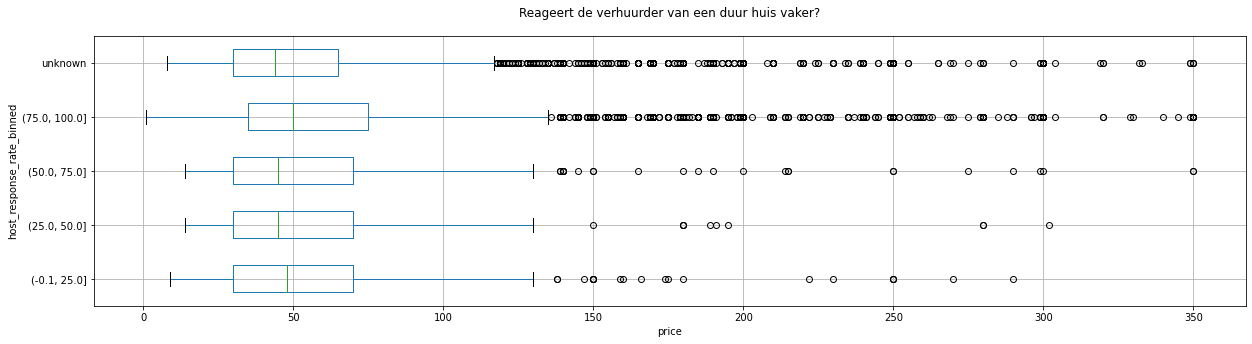

In [103]:
df['float_host_response_rate'] = [float(i.strip('%')) if i!= 'unknown' else i for i in df['host_response_rate']]
df['host_response_rate_binned'] = pd.cut(df['float_host_response_rate'].replace('unknown', np.nan), bins=4)
df['host_response_rate_binned'] = df['host_response_rate_binned'].values.add_categories("unknown").fillna("unknown")
response_rate_binned = df.boxplot(column='price', by='host_response_rate_binned', vert=False, figsize=(20,5))
response_rate_binned.set_xlabel('price')
response_rate_binned.set_ylabel('host_response_rate_binned')
response_rate_binned.set_title('')
plt.suptitle('Reageert de verhuurder van een duur huis vaker?');

<br></br>
*Heeft het aantal huizen dat de host verhuurd invloed op de prijs?*

In [104]:
df['host_listings_count'].nlargest(10)

15847    1676.0
15848    1676.0
17952    1676.0
19280     378.0
5312      118.0
14097      67.0
14098      67.0
16398      67.0
11891      59.0
11892      59.0
Name: host_listings_count, dtype: float64

`host_listings_count` heeft veel outliers, deze besluit ik te verwijderen.

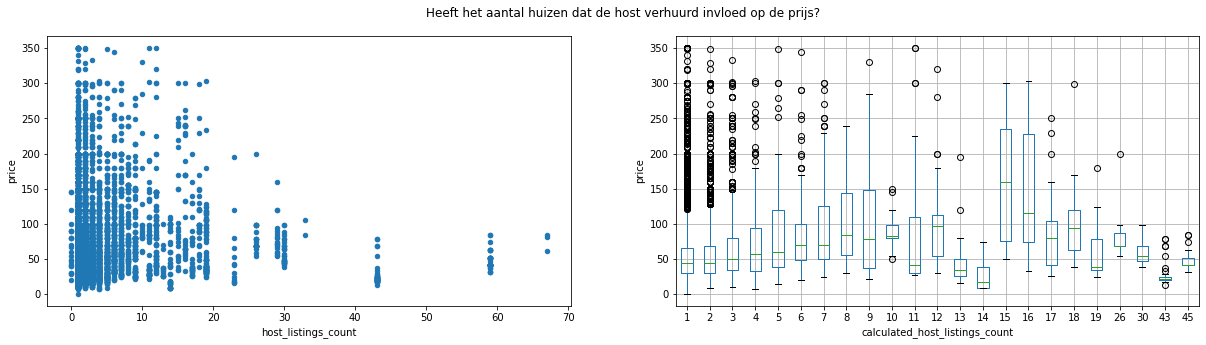

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
df = df[df['host_listings_count'] < 100]
df.plot.scatter('host_listings_count', 'price', ax=axes[0])
listings_count = df.boxplot(column='price',  by='calculated_host_listings_count', ax=axes[1])
listings_count.set_ylabel('price')
listings_count.set_title('')
fig.suptitle('Heeft het aantal huizen dat de host verhuurd invloed op de prijs?');

<br></br>
*Een host met meer verificaties verhuurt duurdere huizen?*

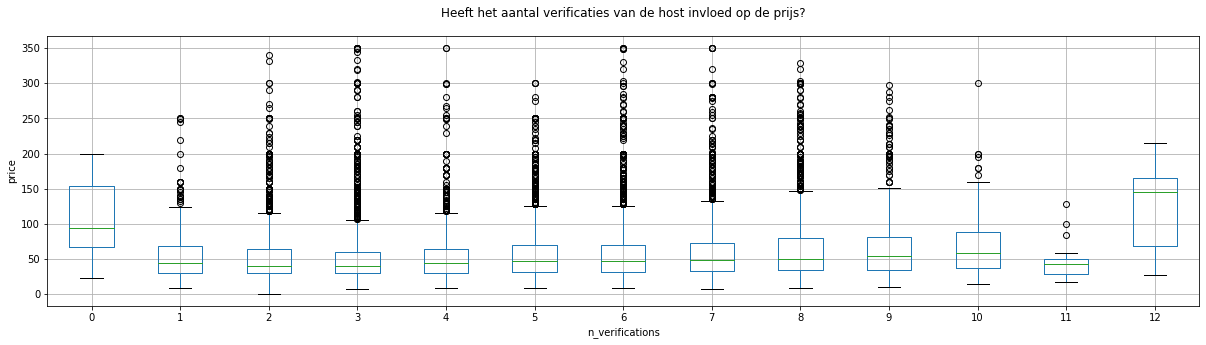

In [110]:
df['listed_verifications'] = [ast.literal_eval(i) for i in df['host_verifications']]
df['n_verifications'] = [len(i) for i in df['listed_verifications']]
n_verifications = df.boxplot(column='price',  by='n_verifications', figsize=(20,5));
n_verifications.set_ylabel('price')
n_verifications.set_title('')
plt.suptitle('Heeft het aantal verificaties van de host invloed op de prijs?');

In [111]:
df['host_verifications'][0]

"['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']"

`host_verifications` is een aparte kolom doordat de velden strings met lijsten bevatten, ik doe de volgende stappen om hiermee te dealen: <a id='lijst_stappen'></a>


1. Ik zet de lijsten om naar *dummy variabelen*: in essentie krijgt elke soort verificatie nu een eigen binary variable.

<AxesSubplot:>

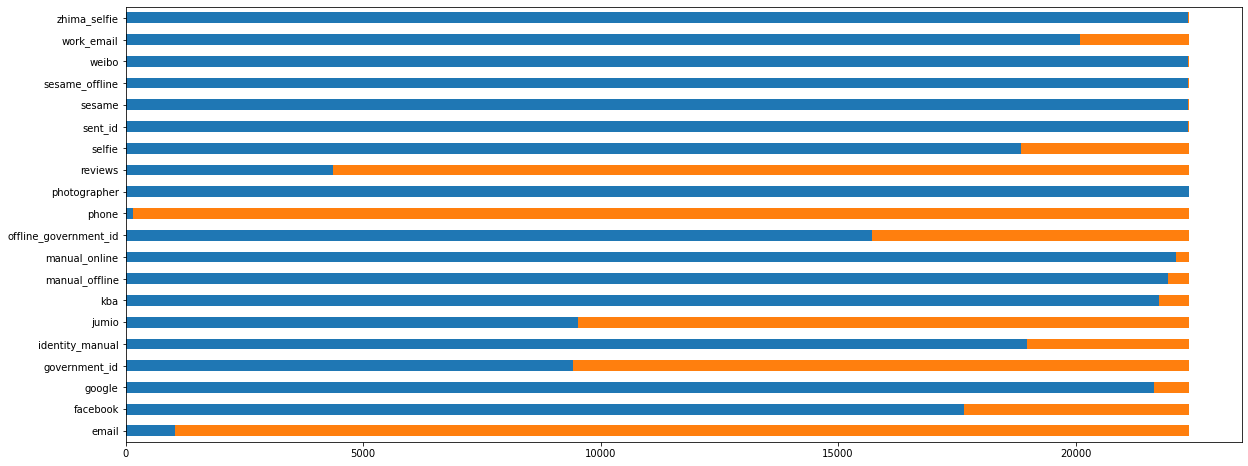

In [112]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

dummies = pd.DataFrame(mlb.fit_transform(df['listed_verifications']),columns=mlb.classes_, index=df.index)

fig = pd.DataFrame([dummies[i].value_counts() for i in dummies])
fig.plot(kind='barh', stacked=True, figsize=(20,8), legend=False)

2. Ik verwijder net als [eerder](#class_inbalans) verificaties met enorme class imbalanses. In dit geval zet ik een threshold van 10%.

In [113]:
for i in dummies.columns:
    if dummies[i].value_counts(normalize=True).max() > 0.90:
        dummies.drop([i], axis=1, inplace=True)

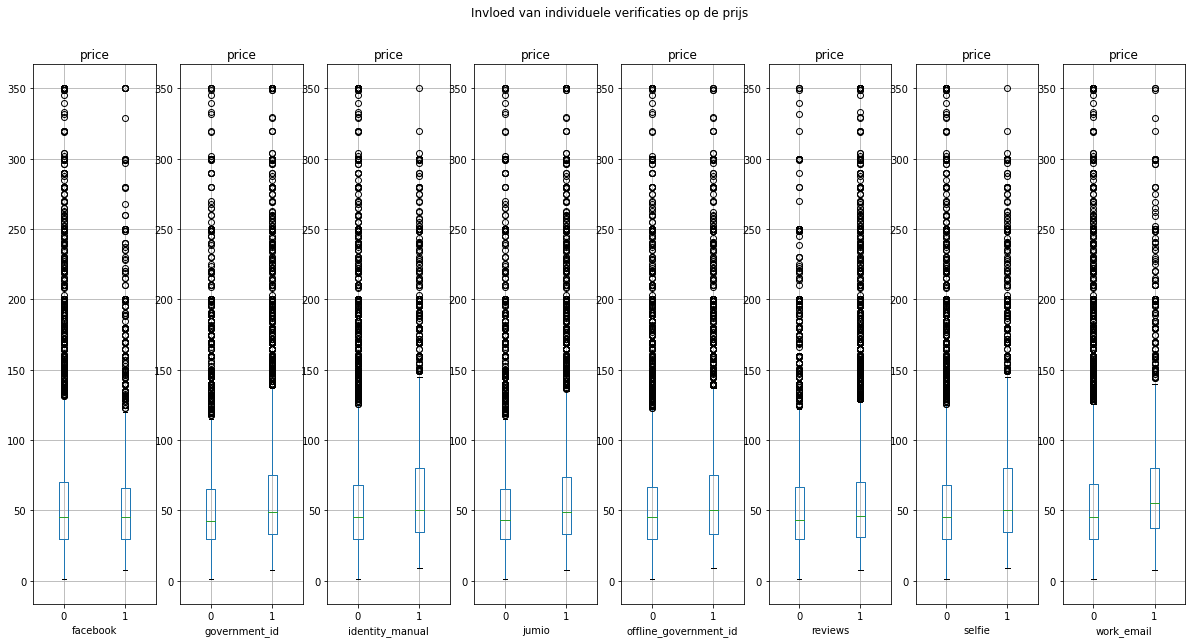

In [114]:
df = pd.concat([df, dummies],axis=1)
fig, axes = plt.subplots(nrows=1, ncols=len(dummies.columns), figsize=(20,10))
for i,j in enumerate(dummies.columns):
    df.boxplot(column='price',  by=j, ax=axes[i]);
plt.suptitle('Invloed van individuele verificaties op de prijs');

3. Ik filter collineaire verificaties

<AxesSubplot:>

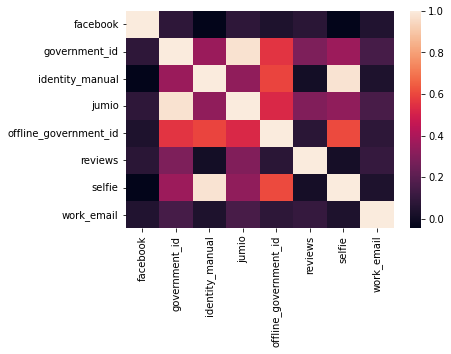

In [115]:
sns.heatmap(dummies.corr())

In [116]:
# De gekozen features
host_features = ['facebook', 'selfie', 'reviews', 'work_email', 'host_identity_verified', 'host_is_superhost', 'calculated_host_listings_count', 
                'n_verifications', 'host_response_time', 'host_response_rate_binned']

<br/><br/>
### Locatie
`latitude, longitude, neighbourhood_cleansed, neighbourhood_group_cleansed, zipcode`

*Listings zijn duurder in het centrum?*

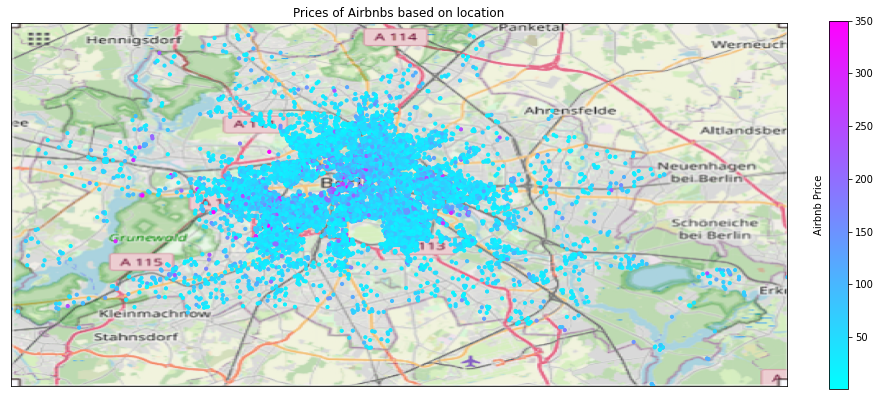

In [117]:
BBox = (df_original.longitude.min(),   df_original.longitude.max(),      
         df_original.latitude.min(), df_original.latitude.max())

ruh_m = plt.imread('img/berlin.png')
plt.figure(figsize=(15, 15))
m = plt.scatter(df['longitude'], df['latitude'], label=None, c=df['price'], cmap='cool', s=10, alpha=1)
cbar = plt.colorbar(fraction=0.022, pad=0.05)
cbar.set_label('Airbnb Price', labelpad=-60)
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(ruh_m, zorder=0, extent = BBox, aspect='equal')
plt.title('Prices of Airbnbs based on location')

m.axes.get_xaxis().set_ticks([]);
m.axes.get_yaxis().set_ticks([]);

<br></br>
*AirBnBs zijn duurder in bepaalde wijken?*

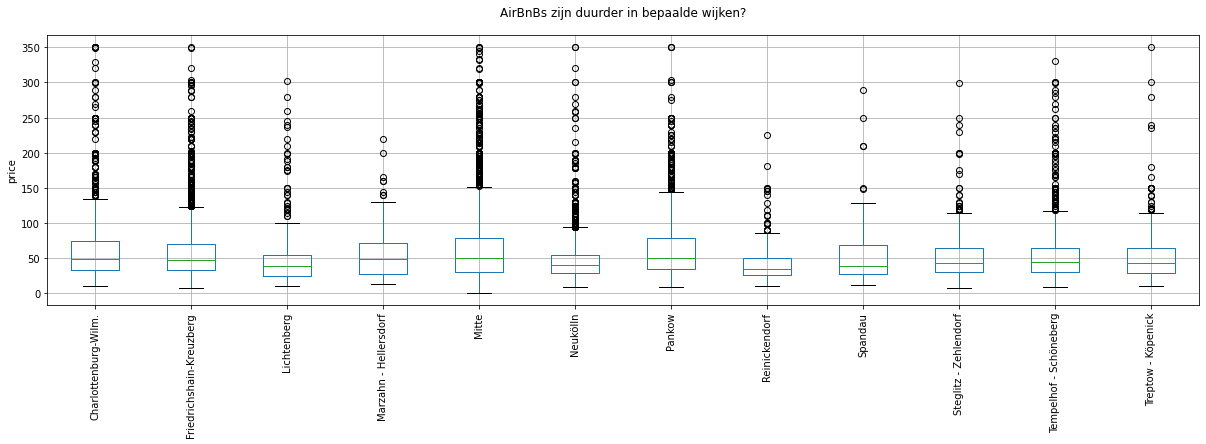

In [145]:
bplt = df.boxplot(column='price',  by='neighbourhood_group_cleansed', figsize=(20,5), rot=90);
bplt.set_ylabel('price');
bplt.set_xlabel('');
bplt.set_title('');
plt.suptitle('AirBnBs zijn duurder in bepaalde wijken?');

In [135]:
location_features = ['longitude', 'latitude', 'neighbourhood_group_cleansed']

<br></br>
## Huis
`accommodates, amenities, bathrooms, bedrooms, beds, bed_type, room_type, property_type`

*Meer/betere voorzieningen zorgen voor een hogere prijs?*

In [137]:
df['amenities'][0]

'{TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Family/kid friendly","Smoke detector",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Private living room",Bathtub,"Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Stove,"Luggage dropoff allowed","Long term stays allowed"}'

Het formaat van `amenities` is vergelijkbaar met die van `host_verifications`, daarom volg ik hetzelfde [stappenplan](#lijst_stappen) als eerder.

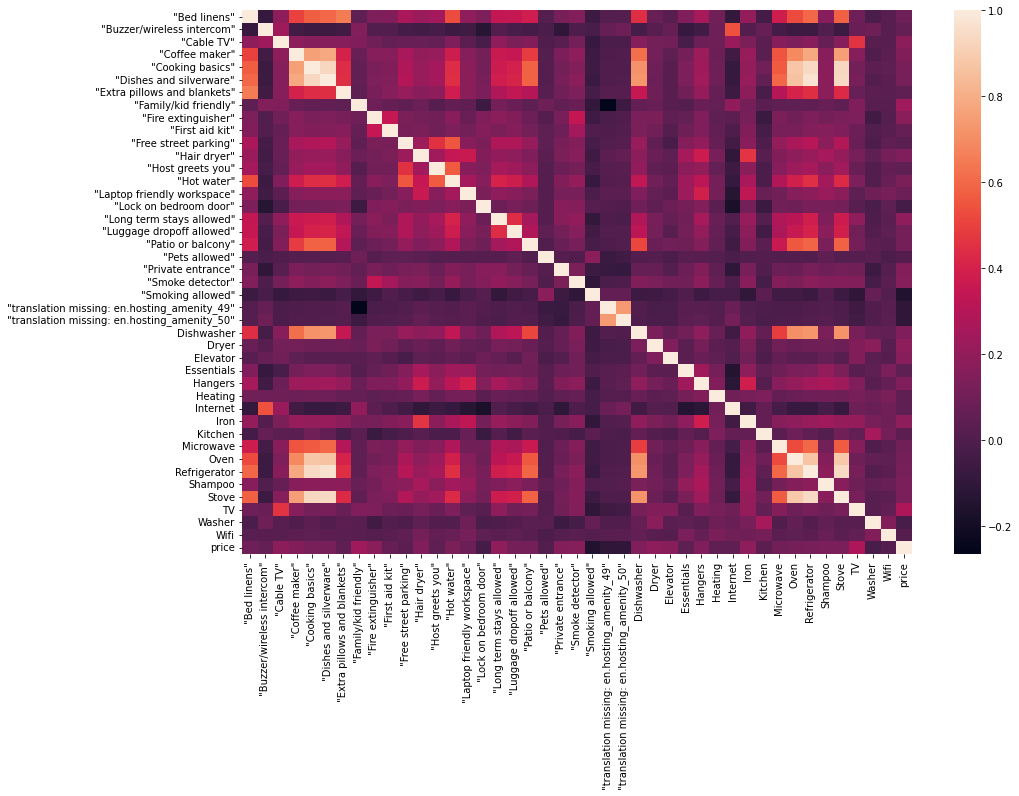

In [140]:
# Amenities one-hot encoden
df['listed_amenities'] = [i[1:-1].split(',') for i in df['amenities']]
dummies = pd.DataFrame(mlb.fit_transform(df['listed_amenities']),columns=mlb.classes_, index=df.index)

# Extreme class imbalances droppen
for i in dummies.columns:
    if dummies[i].value_counts(normalize=True)[0] > 0.90:
        dummies.drop([i], axis=1, inplace=True)

# Plot correlation heatmap
plt.figure(figsize=(15,10))
dummies_w_price = pd.concat([dummies, df['price']], axis=1)
sns.heatmap(dummies_w_price.corr());

Omdat er in dit geval een enorm aantal categorieen zijn, kies ik er handmatig een paar die het met prijs correleren.

In [141]:
dummies = dummies[['TV', '"Family/kid friendly"', '"Long term stays allowed"', '"Private entrance"', '"Smoking allowed"', 'Iron', 'Dryer' ]]
df = pd.concat([df, dummies], axis=1)

<br/><br/>
*Leid een groter aantal gasten dat een huurder kan huisvesten tot een duurdere prijs?*

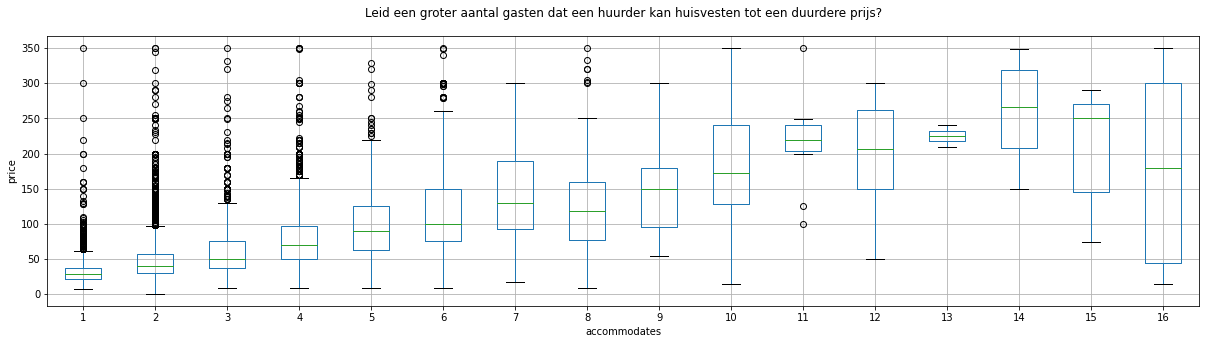

In [143]:
bplt = df.boxplot(column='price',  by='accommodates', figsize=(20,5));
bplt.set_ylabel('price');
bplt.set_xlabel('accommodates');
bplt.set_title('');
plt.suptitle('Leid een groter aantal gasten dat een huurder kan huisvesten tot een duurdere prijs?');

<br/><br/>
*Leidt een groter aantal slaapkamers en badkamers tot een duurdere prijs?* 

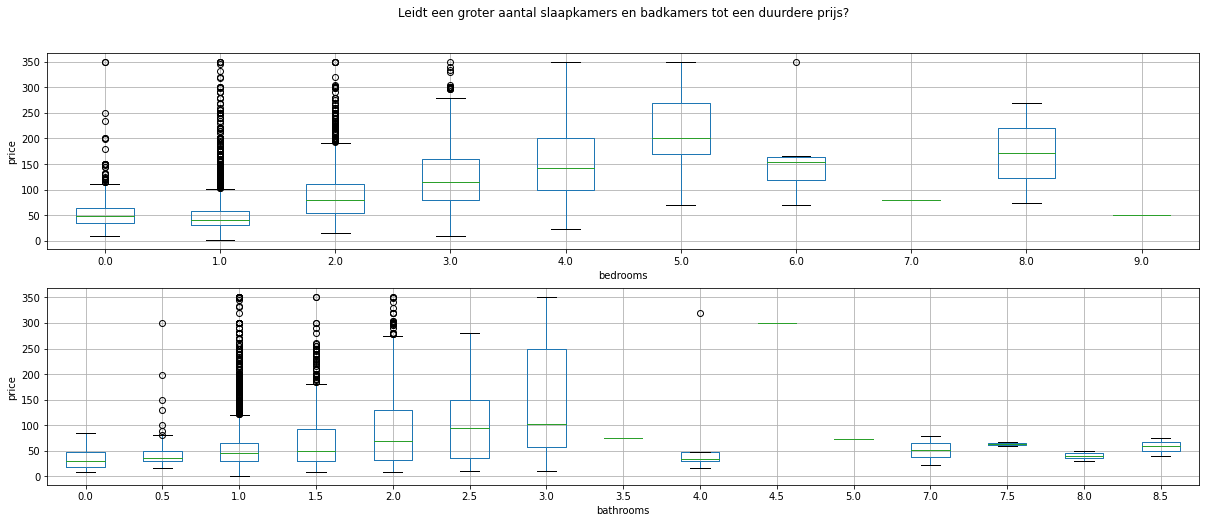

In [152]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
bplt1 = df.boxplot(column='price',  by='bedrooms', ax=axes[0]);
bplt1.set_ylabel('price')
bplt1.set_title('')
bplt2 = df.boxplot(column='price',  by='bathrooms', ax=axes[1]);
bplt2.set_ylabel('price')
bplt2.set_title('')
plt.suptitle('Leidt een groter aantal slaapkamers en badkamers tot een duurdere prijs?');

<br/><br/>
*Heeft het soort bed invloed op de prijs?*

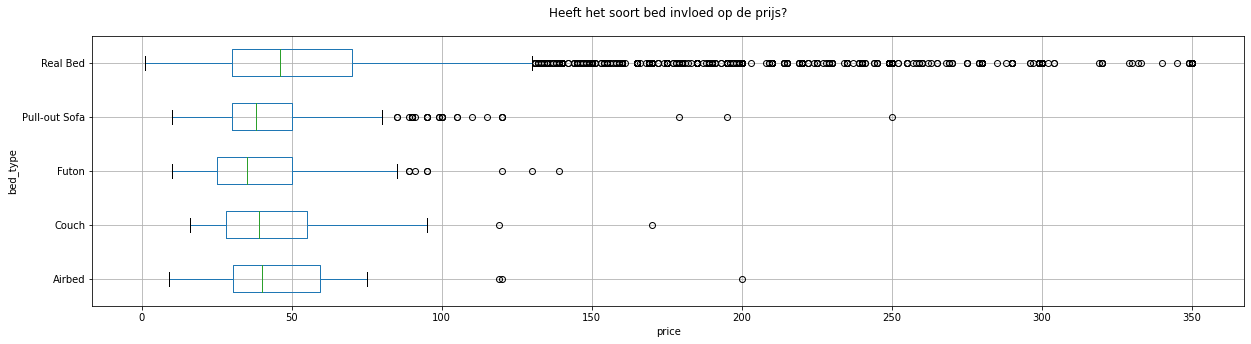

In [156]:
bplt = df.boxplot(column='price',  by='bed_type', figsize=(20,5), vert=False);
bplt.set_ylabel('bed_type')
bplt.set_xlabel('price')
bplt.set_title('')
plt.suptitle('Heeft het soort bed invloed op de prijs?');

<br></br>
*Heeft het soort pand invloed op de prijs?*

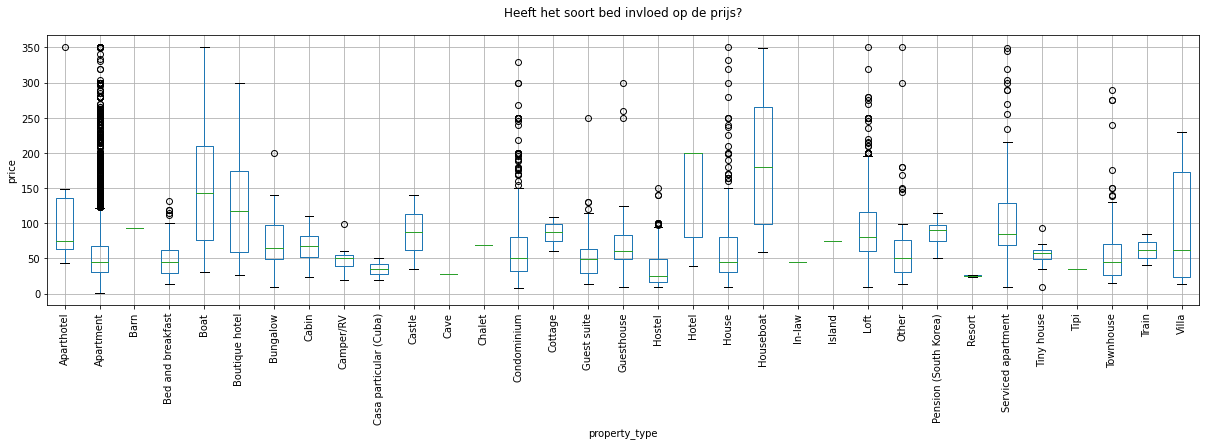

In [157]:
bplt = df.boxplot(column='price',  by='property_type', figsize=(20,5), rot=90);
bplt.set_ylabel('price')
bplt.set_title('')
plt.suptitle('Heeft het soort bed invloed op de prijs?');

In [158]:
house_features = ['bathrooms', 'bedrooms',	'accommodates', 'room_type', 'bed_type', 'property_type'] + list(dummies.columns)

<br></br>
## Boeken

`cancellation_policy, instant_bookable`

*Duurdere huizen hebben een strenger annuleringsbeleid, en zijn minder vaak gelijk te boeken?*

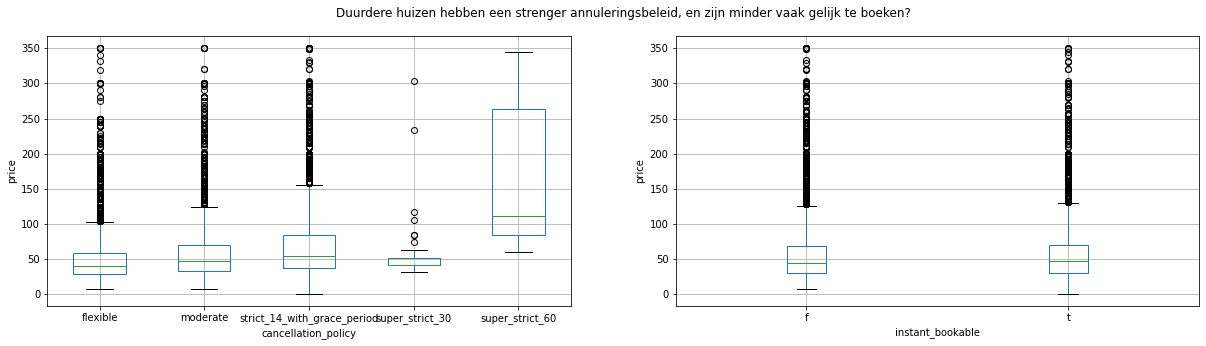

In [175]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
bplt1 = df.boxplot(column='price',  by='cancellation_policy', ax=axes[0])
bplt1.set_ylabel('price')
bplt1.set_title('')
bplt2 = df.boxplot(column='price',  by='instant_bookable', ax=axes[1])
bplt2.set_ylabel('price')
bplt2.set_title('')
fig.suptitle('Duurdere huizen hebben een strenger annuleringsbeleid, en zijn minder vaak gelijk te boeken?');

In [176]:
booking_features = ['cancellation_policy']

<br></br>
## Reviews

`number_of_reviews, review_scores_rating`

<br/><br/>
*Een duurder huis heeft betere reviews?*

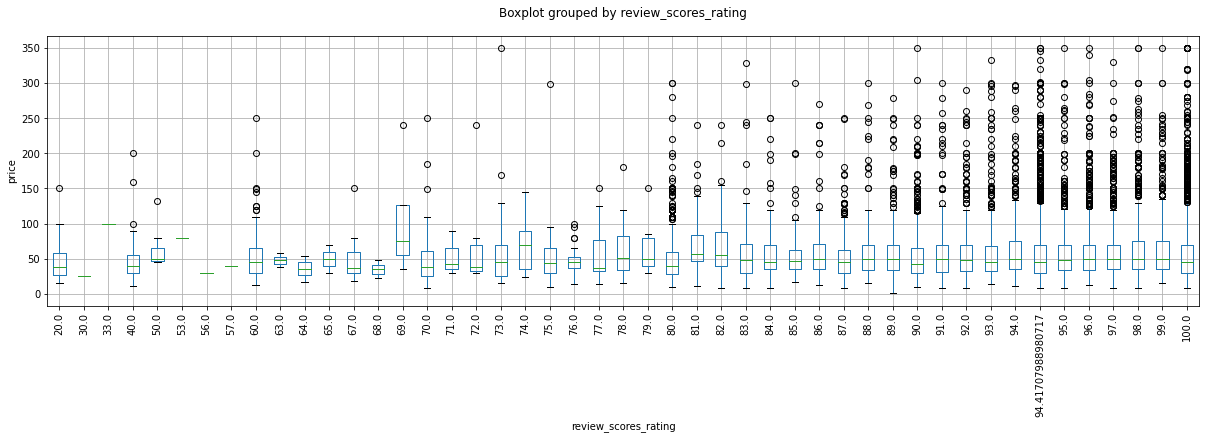

In [163]:
bplt = df.boxplot(column='price',  by='review_scores_rating', figsize=(20,5), rot=90);
bplt.set_ylabel('price');
bplt.set_title('');

<br/><br/>
*Een duurder huis wordt vaker gehuurd en heeft daarom meer reviews?*

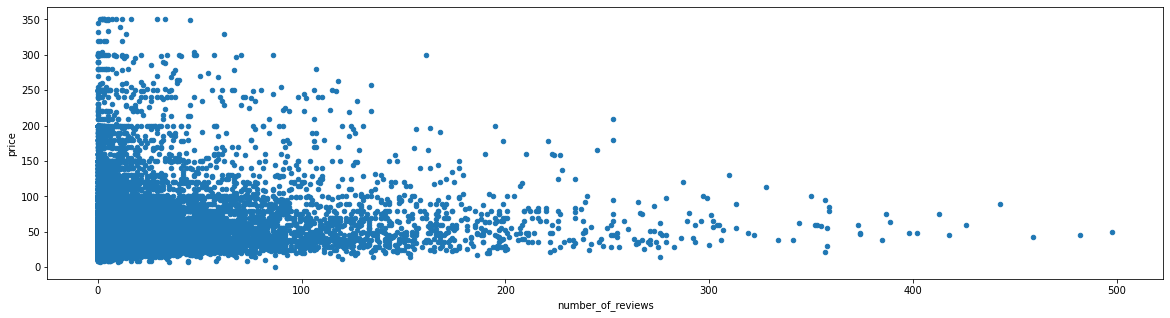

In [164]:
df.plot.scatter(y='price',  x='number_of_reviews', figsize=(20,5));

In [165]:
review_features = ['review_scores_rating', 'number_of_reviews']

## Beschikbaarheid
`minimum_nights, maximum_nights, availability_90`

<br></br>
*Heeft het minimum/maximum aantal nachten invloed op de prijs?*

       minimum_nights  maximum_nights
count    22380.000000    2.238000e+04
mean         7.178239    1.038365e+05
std         40.804006    9.677492e+06
min          1.000000    1.000000e+00
25%          2.000000    2.000000e+01
50%          3.000000    1.124000e+03
75%          4.000000    1.125000e+03
max       5000.000000    1.000000e+09


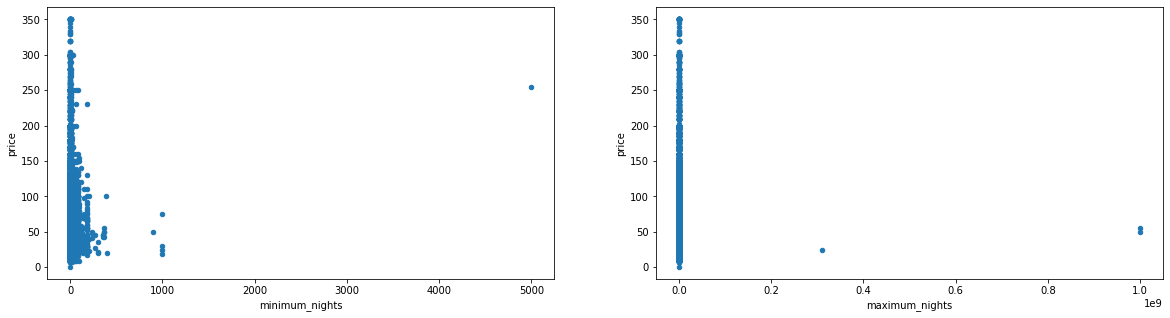

In [166]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
df.plot.scatter(y='price',  x='minimum_nights', ax=axes[0])
df.plot.scatter(y='price',  x='maximum_nights', ax=axes[1])

print(df[['minimum_nights', 'maximum_nights']].describe())

Deze variabelen hebben wat enkele outliers, deze verwijderen we uit de dataset.

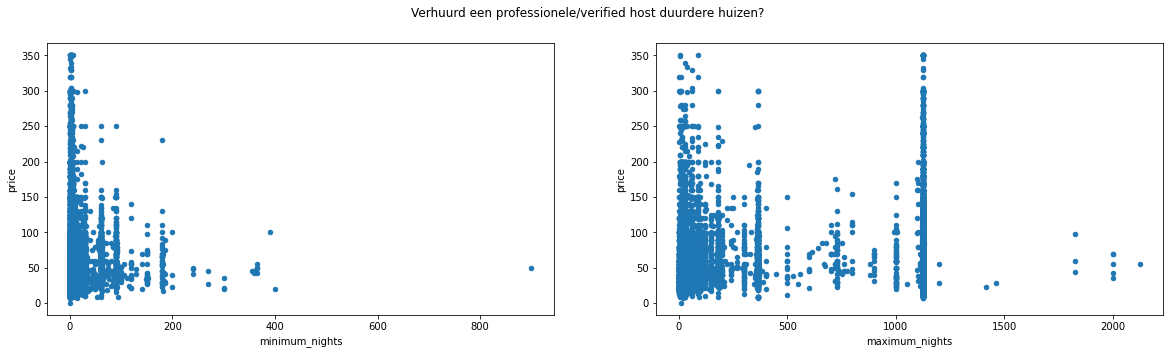

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
df = df[(df['minimum_nights'] < 1000) & (df['maximum_nights'] < 2500)]
df.plot.scatter(y='price',  x='minimum_nights', ax=axes[0])
df.plot.scatter(y='price',  x='maximum_nights', ax=axes[1])
fig.suptitle('Verhuurd een professionele/verified host duurdere huizen?');

<br></br>
*Een duurder huis is minder beschikbaar?*

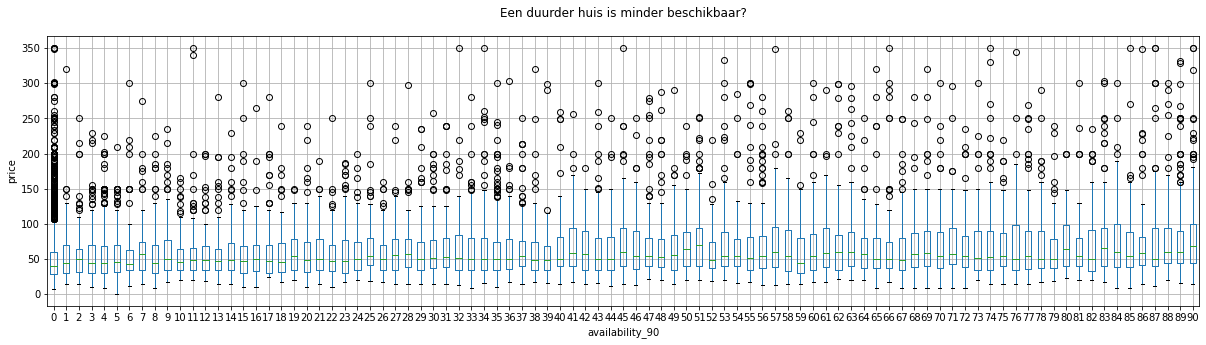

In [168]:
bplt = df.boxplot(column='price', by='availability_90',  figsize=(20,5))
bplt.set_ylabel('price')
bplt.set_title('')
plt.suptitle('Een duurder huis is minder beschikbaar?');

<br></br>
## Kosten
`security_deposit, cleaning_fee, extra_people, guests_included`

*Duurdere huizen hebben meer onkosten?*

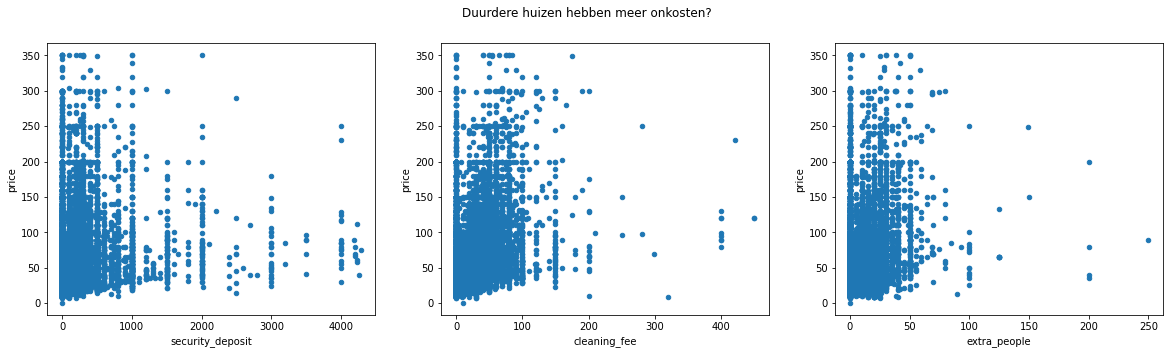

In [169]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
df.plot.scatter(y='price',  x='security_deposit', ax=axes[0])
df.plot.scatter(y='price',  x='cleaning_fee', ax=axes[1])
df.plot.scatter(y='price',  x='extra_people', ax=axes[2])
fig.suptitle('Duurdere huizen hebben meer onkosten?');

<br></br>
*Een duurder huis heeft meer gasten inbegrepen in de booking fee?*

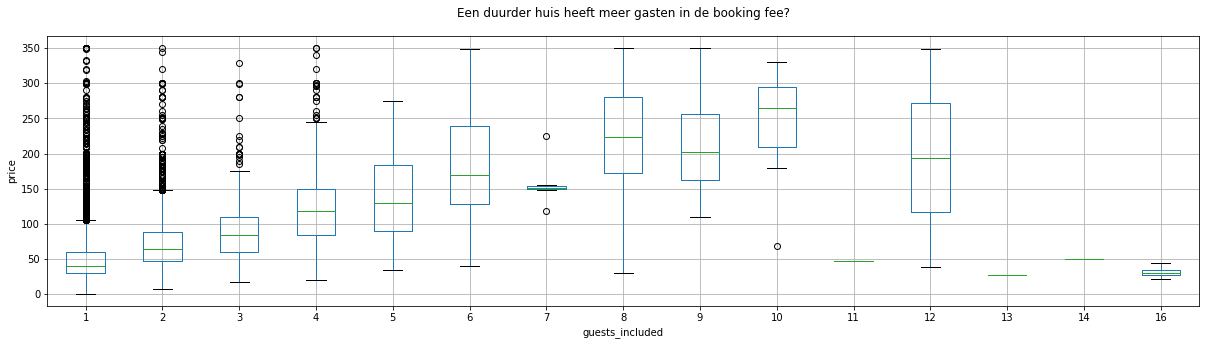

In [173]:
bplt = df.boxplot(column='price', by='guests_included',  figsize=(20,5));
bplt.set_ylabel('price');
bplt.set_title('');
plt.suptitle('Een duurder huis heeft meer gasten in de booking fee?');

In [60]:
cost_features = ['security_deposit', 'cleaning_fee', 'guests_included','extra_people']

<a id='preprocessing'> <h2> (4) Feature preprocessing</h2></a>

In deze fase maak ik de features klaar voor gebruik voor de modellen. De overgrote meerderheid van de modellen leest enkel numerieke variabelen, daardoor is het belangrijk om de categoriale features die we nog hebben te converteren naar deze vorm. Daarna standaardiseren we de data, zodat deze effectief door het model gebruikt kan worden.

De eerste stap is om alle gekozen/gemaakte kolommen samen te voegen in één dataframe.

In [66]:
features = ['price'] + host_features + location_features + house_features + booking_features + cost_features + ['availability_90'] + review_features
df = df[features]
print(f'Percentage van data behouden: {len(df)/len(df_original)}')

Percentage van data behouden: 0.9914420007094714


In [67]:
df.head(3)

,price,facebook,selfie,reviews,work_email,host_identity_verified,host_is_superhost,calculated_host_listings_count,n_verifications,host_response_time,host_response_rate_binned,longitude,latitude,neighbourhood_group_cleansed,bathrooms,bedrooms,accommodates,room_type,bed_type,property_type,TV,"""Family/kid friendly""","""Long term stays allowed""","""Private entrance""","""Smoking allowed""",Iron,Dryer,cancellation_policy,security_deposit,cleaning_fee,guests_included,extra_people,availability_90,review_scores_rating,number_of_reviews
0,60.0,0,0,1,0,t,t,4,6,within an hour,"(75.0, 100.0]",13.402557,52.534537,Mitte,1.0,1.0,3,Entire home/apt,Real Bed,Guesthouse,1,1,1,0,0,1,0,strict_14_with_grace_period,200.0,30.0,1,28.0,51,93.0,118
1,17.0,0,0,1,0,t,f,1,5,unknown,unknown,13.404553,52.548513,Pankow,1.0,1.0,2,Private room,Real Bed,Apartment,0,0,0,0,0,0,0,flexible,0.0,0.0,1,0.0,0,100.0,6
2,90.0,1,0,1,0,t,f,1,7,within a day,"(75.0, 100.0]",13.417579,52.534996,Pankow,1.0,1.0,4,Entire home/apt,Real Bed,Apartment,0,1,0,0,0,1,0,strict_14_with_grace_period,200.0,50.0,2,20.0,0,92.0,143


De Boolean variabelen die nog aangegeven worden met t(True) en f(False) zet ik om naar binaire variabelen.

In [68]:
for i in df.columns:
    if 't' and 'f' in df[i].unique():
        df[i] = df[i].map(dict(t=1, f=0))

<br></br>
Voor de overige categoriale variabelen heb ik wederom besloten te __one-hot encoden__.

Voor kolommen met veel verschillende categorieën doe ik dit ook, omdat deze niet ordinaal zijn en __label encoding__ (simpelweg omzetten naar nummers) geen optie is. Bij label encoding implementeer je een sequentiele volgorde in je kolom die we in dit geval niet willen.

In [69]:
df = pd.get_dummies(df, columns=['room_type', 'bed_type', 'property_type', 
                                 'cancellation_policy', 'neighbourhood_group_cleansed', 'host_response_time', 'host_response_rate_binned'])

In [70]:
df.head(3)

,price,facebook,selfie,reviews,work_email,host_identity_verified,host_is_superhost,calculated_host_listings_count,n_verifications,longitude,latitude,bathrooms,bedrooms,accommodates,TV,"""Family/kid friendly""","""Long term stays allowed""","""Private entrance""","""Smoking allowed""",Iron,Dryer,security_deposit,cleaning_fee,guests_included,extra_people,availability_90,review_scores_rating,number_of_reviews,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_In-law,property_type_Island,property_type_Loft,property_type_Other,property_type_Pension (South Korea),property_type_Resort,property_type_Serviced apartment,property_type_Tiny house,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Villa,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,neighbourhood_group_cleansed_Charlottenburg-Wilm.,neighbourhood_group_cleansed_Friedrichshain-Kreuzberg,neighbourhood_group_cleansed_Lichtenberg,neighbourhood_group_cleansed_Marzahn - Hellersdorf,neighbourhood_group_cleansed_Mitte,neighbourhood_group_cleansed_Neukölln,neighbourhood_group_cleansed_Pankow,neighbourhood_group_cleansed_Reinickendorf,neighbourhood_group_cleansed_Spandau,neighbourhood_group_cleansed_Steglitz - Zehlendorf,neighbourhood_group_cleansed_Tempelhof - Schöneberg,neighbourhood_group_cleansed_Treptow - Köpenick,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,"host_response_rate_binned_(-0.1, 25.0]","host_response_rate_binned_(25.0, 50.0]","host_response_rate_binned_(50.0, 75.0]","host_response_rate_binned_(75.0, 100.0]",host_response_rate_binned_unknown
0,60.0,0,0,1,0,1,1,4,6,13.402557,52.534537,1.0,1.0,3,1,1,1,0,0,1,0,200.0,30.0,1,28.0,51,93.0,118,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,17.0,0,0,1,0,1,0,1,5,13.404553,52.548513,1.0,1.0,2,0,0,0,0,0,0,0,0.0,0.0,1,0.0,0,100.0,6,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,90.0,1,0,1,0,1,0,1,7,13.417579,52.534996,1.0,1.0,4,0,1,0,0,0,1,0,200.0,50.0,2,20.0,0,92.0,143,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


<br></br>
Ik split de data op in 80% train en 20% test

In [71]:
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'],axis=1), df['price'], test_size=0.2)

Omdat we algoritmes gaan gebruiken die gebaseerd zijn op leren via de gradient, helpt het schalen van onze data erbij om de gradient descent zo soepel mogelijk te laten verlopen. We zorgen hiervoor dat de data op dezelfde schaal is en er dus geen enorme verschillen in magnitude zijn. In dit geval standaardiseer ik de data, dit betekent dat elke kolom een mean van 0 krijgt en een standaardafwijking van 1.

In [73]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

<a id='ml'> <h2> (5) Model experimenten</h2></a>

Nu dat alle data voorbereid is, begin ik met experimenteren met voorspellende modellen. Hierbij beginnen we met de meest simpele modellen en proberen we steeds complexere modellen. Dit doe ik om de volgende redenen:
1. Complexere modellen zijn moeilijker te interpreteren: Hierdoor is het ook moeilijker om vast te stellen hoe het model tot de voorspelling is gekomen, dit is zeker belangrijk als het model in de praktijk gebruikt wordt.
2. Een simpeler model kan veel meer tijd besparen: Niet alleen in het bouwen/experimenteren van het model, maar ook bij het bijhouden van het model in de toekomst.

Hierdoor geef ik de voorkeur aan simpelere modellen wanneer het resultaat in vergelijking met een heel complex model niet zoveel verschilt.

### Baseline / Sanity Check

Als eerste vind ik het altijd fijn om een soort sanity check te doen. In dit geval gebruik ik de gemiddelde prijs als eerste voorspelling. Om alle modellen de evaluaren gebruik ik de root mean squared error op de test set.

In [75]:
from sklearn.metrics import mean_squared_error
baseline = np.full(len(y_test), df['price'].mean())
rmse = mean_squared_error(baseline, y_test, squared=False)
print(f"Baseline RMSE: {round(rmse, 4)}")

Baseline RMSE: 40.8785


### Linear regression

Na de baseline begin ik met het meest simpele model. Linear regression probeert een plane te fitten over de data, zonder enige vorm van regularization.

In [76]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred_test = linear.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(rmse, 4)}")

RMSE: 318726361984.8637


### Ridge
Linear regression doet het heel erg slecht, dus nu introduceer ik twee lineaire modellen met een __regularizer__, te beginnen met Ridge regression (L2). Ridge regression voegt een penalty term `alpha` toe aan de loss functie en zorgt er voor dat er een beetje bias wordt geintroduceerd om te veel variance (overfitting) te voorkomen. 

Om de hyperparameter `alpha` te optimaliseren gebruik ik *scikit-learn's gridsearch cross validation*. Met deze techniek word de training set opgesplitst in een n aantal folds, waarvan er eentje de validation set is en de rest de training set. Vervolgens wordt voor een hyperparameter de data n keer getrained en getest, waarbij de validation set elke keer een andere fold is. Tenslotte wordt de hyperparameter met de laagste gemiddelde score (over alle folds) gekozen. Het model met deze hyperparameter gebruiken we om te testen op de testset. 

In [79]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.0001, 0.001,0.01,0.1, 1.0, 10, 100, 1000]}
ridge = GridSearchCV(Ridge(), params, cv=3, refit=True)

ridge.fit(X_train, y_train)
y_pred_test = ridge.predict(X_test) 

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'Beste parameters: {ridge.best_params_}') 
print(f"RMSE: {round(rmse, 4)}")

Beste parameters: {'alpha': 100}
RMSE: 28.3465


### Lasso

Voor Lasso (L1 regularizer) volgen we een zelfde soort proces.

In [77]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.0001, 0.001,0.01,0.1, 1.0, 10, 100, 1000]}
lasso= GridSearchCV(Lasso(), params, cv=3, refit=True)

lasso.fit(X_train, y_train)
y_pred_test = lasso.predict(X_test) 

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(lasso.best_params_) 
print(f"RMSE: {round(rmse, 4)}")

{'alpha': 0.1}
RMSE: 28.357


### Gradient Boosting: XGboost
Tenslotte gebruik ik een gradient boosting model, in dit geval XGBoost. Dit is naar mijn eigen ervaring een goed all-round model voor regressie. Het model is gebaseerd op decision trees waarbij opeenvolgend nieuwe modellen worden gemaakt om de fouten van de eerdere modellen te corrigeren. Ook hier gebruik ik weer de cross validation gridsearch, deze duurt alleen een stuk langer omdat we veel meer hyperparameters hebben.

In [90]:
import xgboost as xgb

booster = xgb.XGBRegressor()

params =      {'n_estimators': [150, 200, 250],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth':  [4, 5, 6, 7, 8],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}


booster_GSCV = GridSearchCV(booster, params, cv=3, n_jobs=-1)
booster_GSCV.fit(X_train, y_train)

booster = xgb.XGBRegressor(**booster_GSCV.best_params_)
booster.fit(X_train, y_train)

y_pred_test = booster.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(booster_GSCV.best_params_) 
print(f"RMSE: {round(RMSE, 4)}")

{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 250}
RMSE: 24.7558


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

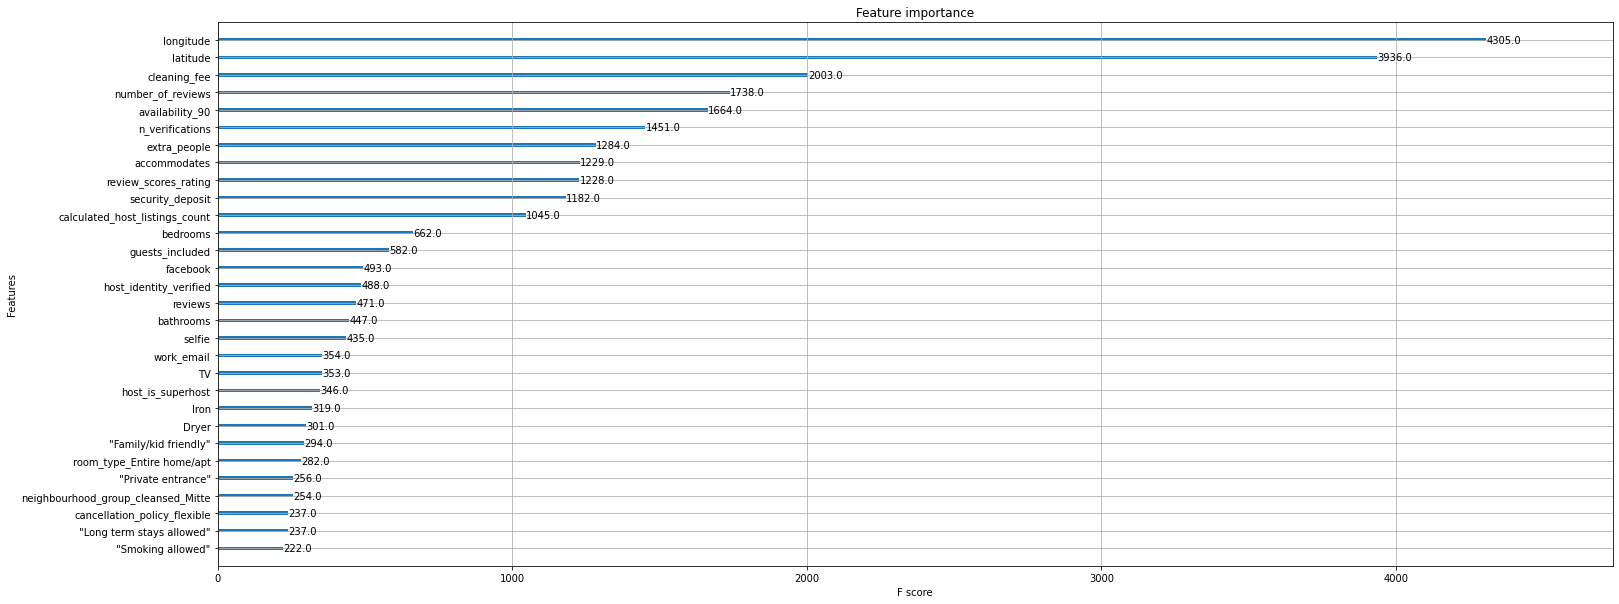

In [92]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(25,10))
booster.get_booster().feature_names = list(df.drop(['price'],axis=1).columns)
plot_importance(booster, max_num_features = 30, ax=ax)

In deze plot kunnen we zien welke features het belangrijkst zijn, we kunnen hiermee twee dingen doen:
1. Backtracken naar [Feature Analysis/Engineering](#engineering): we kunnen hiermee zien welke features het meeste invloed hebben in de voorspelling en dus focussen op wat meer feature engineering die in dezelfde semantische categorie behoren. Bijvoorbeeld: we zien dat `latitude,longitude` en dus locatie heel veel invloed heeft, daardoor zouden we meer locatie features kunnen engineeren (bijv. afstand naar het centrum).
2. De voorspelling uitleggen aan gebruiker: we kunnen aangeven welke factoren de meeste invloed hebben op de prijsvoorspelling en daardoor uitleggen hoe het model tot een voorspelling is gekomen.

In de praktijk kan dit model gebruikt worden om de verhuurder te helpen met zijn huis een prijs te geven die zijn inkomen zal maximaliseren. Een prijs inschatten is vaak een lastige trade-off: bij een te goedkoop huis maak je minder winst en bij een te duur huis sluit je waarschijnlijk veel mensen uit. Het model zou gebruikt kunnen worden om een indicatie/range te geven van wat je huis waard is op basis van de data van andere airbnbs.

Een aantal dingen zouden nog verbeterd kunnen worden aan de aanpak:
- Een uitgebreidere gridsearch op meer folds.
- Zoals hierboven gezegd: nadat we de features met hoge invloed hebben gevonden, hier meer features op engineeren en features met weinig invloed filteren.
- NLP technieken toepassen op de `description` kolom. Mogelijk kunnen we hier informatie uit halen zoals de grootte van het pand of misschien zelfs iets over de prijs. Ook zouden we een sentiment analysis kunnen doen, misschien heeft past een positievere beschrijving bij een duurder huis.
- Met nog meer modellen experimenteren: er zijn nog heel veel regressie modellen die ik hier niet gebruikt heb o.a ElasticNet of Neural Networks.